In the previous notebook, we set up an LSTM model a SPY return prediction problem. Here, we want to investigate what happens with the predictions when we normalize the input sequence ahead of time. Can it predict things well? 

In [30]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import yfinance as yf
import matplotlib.pyplot as plt

# Importing scikit-learn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Keras imports for use later 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Normalization
from tensorflow.keras.utils import plot_model

In [5]:
spy = yf.download(tickers = 'SPY', progress=False)
spy_log_close = spy['Adj Close'].apply(np.log)
log_returns = spy_log_close.diff()

In [28]:
features = pd.DataFrame() 

n_periods = 20

for i in range(n_periods, 0, -1): 
    features[f'Ret_{i}'] = log_returns.shift(i)

target = log_returns.shift(-1)
target.name = 'target'

all_data = pd.concat([features, target], axis = 1).dropna()    

In [40]:
# We need the mean and sigma that we are going to use for standardization
train_pct = 0.7
train_ending_index = int(log_returns.shape[0] * train_pct)
train_ending_index_datetime = log_returns.index[train_ending_index]

mu = 0

sigma = log_returns.iloc[:train_ending_index].std()


In [61]:
def standardize_data(x, mu: float, sigma: float) -> float: 
    return (x - mu)/sigma

def unstandardize_data(x, mu: float, sigma: float) -> float: 

    return (x * sigma) + mu

In [59]:
train_data = all_data.loc[:train_ending_index_datetime]
test_data = all_data.loc[train_ending_index_datetime + pd.Timedelta(days = 1):]

# Standardizing this data
train_data_standardized = train_data.apply(standardize_data, **{'mu': mu, 'sigma': sigma})
test_data_standardized = test_data.apply(standardize_data, **{"mu": mu, "sigma": sigma})

# Then we going to take some of the test_data for validation
val_pct = 0.25
val_size = int(test_data_standardized.shape[0] * val_pct)

val_data_standardized = test_data_standardized.iloc[:val_size]
test_data_standardized.drop(val_data_standardized.index, axis = 0, inplace=True)

In [60]:
train_features, train_target = train_data_standardized.iloc[:, :-1].to_numpy(), train_data_standardized.iloc[:, -1].to_numpy() 
val_features, val_target = val_data_standardized.iloc[:, :-1].to_numpy(), val_data_standardized.iloc[:, -1].to_numpy() 
test_features, test_target = test_data_standardized.iloc[:, :-1].to_numpy(), test_data_standardized.iloc[:, -1].to_numpy() 

Setting up our neural network like before

In [ ]:
model = Sequential()
model.add(LSTM(units = 32, return_sequences=True, input_shape = (n_periods, 1)))
model.add(LSTM(units = 32, return_sequences=False))
model.add(Dense(units = 1, activation = 'linear')) 

# Then we compile this model
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = tf.keras.losses.MeanAbsoluteError(), 
    metrics = ['mse', 'mae']
)

In [ ]:
# Doing a quick fit of this for 30 epochs
history = model.fit(
    x = train_features, 
    y = train_target, 
    validation_data = (val_features, val_target), 
    epochs = 30
)

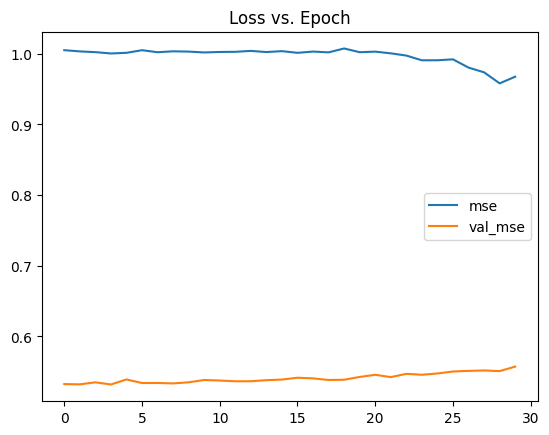

In [82]:
history_df = pd.DataFrame(history.history)
history_df[['mse', 'val_mse']].plot()
plt.title("Loss vs. Epoch")
plt.show()

In [83]:
test_predictions = model.predict(test_features).flatten()

2023-07-01 09:19:09.083258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 09:19:09.084419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 09:19:09.086787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

54/54 [==============================] - 1s 4ms/step


In [84]:
mean_squared_error(test_target, test_predictions)

1.015692271862499

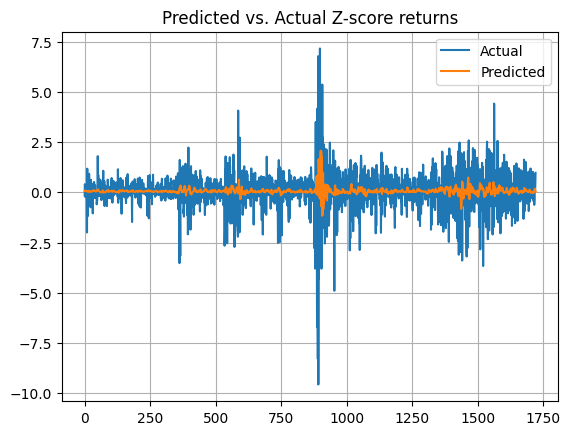

In [85]:
plt.plot(test_target, label = 'Actual')
plt.plot(test_predictions, label = 'Predicted')
plt.title("Predicted vs. Actual Z-score returns")
plt.legend()
plt.grid()
plt.show()


### Conclusion

We see that the model is not doing a great job at getting the returns right here. It is predicting things too small and it probably comes from the fact that daily returns do not have much information in them

Things that we can do from this: 
* Use fractional time series -> Marcos Lopez de Prado brought this up. There is an optimal amount of differencing that you can do retain memory in your series while maintaining stationarity. We could revisit this concept and apply it 
* Look for better parameters in this model
    * The things that we can toggle are: How many LSTM units, how many layers of LSTM units? The amount of periods that we look into the past for our data
* We know that these time series are not stationary and especially that there is an aspect of conditional volatility. What if we scale the data based on some conditional volatility model rather than a global standard deviation and mean that we apply? Can the model perform better there? 
* Maybe we can work with another time series? 
    * Another asset 
    * A different time scale (hourly returns, weekly returns)

These are all areas of research for this problem of trying to predict something. 

There is some house keeping we need to do with this pipeline too. The pipeline is
* Creating your time series of returns 
* Generating the features and scaling them 
    * The parameter here is how many periods we are looking back for returns
* Splitting into training, testing, and validation